## Image Classification on the cifar dataset using CNN

Step 1: Import the libraries

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import functools
import sklearn.preprocessing 

C:\Users\Monica\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Setting some global variables for filepath and network architecture

In [2]:
cifar10_dataset_folder_path= 'cifar-10-batches-py'

n_nodes_hl1 = 500
n_nodes_hl2 = 500
n_nodes_hl3 = 500

n_classes = 10 #data belongs to classes {'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}
n_inputs = 3072 #image size is 32X32 and 3 channels - 
batch_size = 25 #50
keep_prob = 0.5
#keep_prob = 1.0
num_training = 10000
num_testing = 2000

Methods for loading the data from the internet

In [3]:
class DLProgress(tqdm):
    last_block= 0
    
    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total= total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block= block_num
        
        
if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz','cifar-10-python.tar.gz',pbar.hook)
        
if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

Helper methods to load records, get stats, display images

In [4]:
def _load_label_names():
    """
    Load the label names from file
    """
    
    return['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)
    #plt.show(sample_image)
    plt.show()

Methods to pre-process and load data records from file

In [5]:
def normalize(list_image_data):
    
    x = np.array(list_image_data)
    x_max = np.max(x)
    x_min = np.min(x)
    output = (x - x_min)/(x_max - x_min)
    return output
    ''' 
    if(list_image_data.ndim == 4):
        p,m,n,r = list_image_data.shape
        img_arr_norm = np.empty(list_image_data.shape, dtype = np.float32)
        
        for i in range(p):
            img = list_image_data[i]
            img_a = img[:, :, 0]
            img_b = img[:, :, 1]
            img_c = img[:, :, 2]  # Extracting single channels from 3 channel image
            # The above code could also be replaced with cv2.split(img) << which will return 3 numpy arrays (using opencv)
            
            # normalizing per channel data:
            img_a = sklearn.preprocessing.normalize(img_a)
            img_b = sklearn.preprocessing.normalize(img_b)
            img_c = sklearn.preprocessing.normalize(img_c)
            
            # putting the 3 channels back together:
            img_arr_norm[i, :, :, 0] = img_a
            img_arr_norm[i, :, :, 1] = img_b
            img_arr_norm[i, :, :, 2] = img_c 
        
        for i in range(p):
            img_a = (img_a - img_a.mean()) / (img_a.std())
            img_b = (img_b - img_b.mean()) / (img_b.std())
            img_c = (img_c - img_c.mean()) / (img_c.std())
            v_mean = img.mean(axis = (0, 1, 2), keepdims = True)
            v_std = img.std(axis = (0, 1, 2), keepdims = True)
            img_norm = (img - v_mean) / v_std
            img_arr_norm[i] = img_norm
                
    else:
        raise Exception("Invalid number of arguments to normalize method.")
            
    
    #img_arr_norm = list_image_data.astype('float32')
    
    #mean = np.mean(img_arr_norm, axis = (0,1,2,3))
    #std = np.std(img_arr_norm, axis = (0,1,2,3))
    #img_arr_norm = (img_arr_norm - mean) / (std+1e-7)
    
    return img_arr_norm 
    #return list_image_data
    '''

def one_hot_encode(label_value_list):
    #all_labels = _load_label_names()
    coded_label_list = []
    for i in range(len(label_value_list)):
        coded_label = [0]*n_classes
        #ind = all_labels.index(label_value)
        #coded_label[ind] = 1
        coded_label[label_value_list[i] - 1] = 1
        coded_label_list.append(coded_label)
    return coded_label_list


def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    #n_batches = 5
    n_batches = 1
    valid_features = []
    valid_labels = []
    
    print("Before normalization: 1st batch, first 5 images")
    display_stats(cifar10_dataset_folder_path, 1, 0)
    display_stats(cifar10_dataset_folder_path, 1, 1)
    display_stats(cifar10_dataset_folder_path, 1, 2)
    display_stats(cifar10_dataset_folder_path, 1, 3)
    display_stats(cifar10_dataset_folder_path, 1, 4)

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)
        #print("validation count: ",validation_count)
        
        #print(features.shape)
        
        if (batch_i == 1):
            unique = functools.reduce(lambda l, x: l+[x] if x not in l else l, labels[0:num_training], [])
            print(unique)
            plt.title("Representation of the different classes in training set.")
            plt.hist(labels[0:num_training], bins = 10, rwidth = 0.5)
            plt.show()
        
        
        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])
        
    
    plt.title("Representation of the different classes in test set.")
    plt.hist(valid_labels[0:num_testing], bins = 10, rwidth = 0.5)
    plt.show()

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the training data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all training data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_testing.p')
    
    _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[0:5],
            labels[0:5],
            'first_five.p')
    
    features2, labels2 = pickle.load(open('first_five.p', mode='rb'))
    
    print("len(features2) : ", len(features2))
    print("len(labels2) : ", len(labels2))
    
    print("After normalization: 1st batch, first five images")
    plt.axis('off')
    plt.imshow(features2[0])
    plt.show()
    
    plt.axis('off')
    plt.imshow(features2[1])    
    plt.show()
    
    plt.axis('off')
    plt.imshow(features2[2])
    plt.show()
    
    plt.axis('off')
    plt.imshow(features2[3])
    plt.show()
    
    plt.axis('off')
    plt.imshow(features2[4])
    #plt.show(sample_image)
    plt.show()
    
    
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        #print(features[start].shape)
        yield features[start:end], labels[start:end] 

More methods for loading and display

In [6]:
def load_all_validation_data(batch_size):
    filename = 'preprocess_validation.p'
    if(isfile(filename)):
        features, labels = pickle.load(open(filename, mode='rb'))
        f,l = features[0:num_testing], labels[0:num_testing]
        return batch_features_labels(f, l, batch_size)
    
def load_all_training_data(batch_size):
    filename = 'preprocess_training.p'
    if(isfile(filename)):
        features, labels = pickle.load(open(filename, mode='rb'))
        return batch_features_labels(features[0:num_training], labels[0:num_training], batch_size)
    else:
        exit(-1)

    

def load_training_batch(batch_size, batch_number):
    filename = cifar10_dataset_folder_path + '/test_batch/'
    filename = 'preprocess_training.p'
    if(isfile(filename)):
        features, labels = pickle.load(open(filename, mode='rb'))
        return batch_features_labels(features, labels, batch_size)
    else:
        exit(-1)
    

def load_validation_batch(batch_size, batch_number):
    #filename = cifar10_dataset_folder_path + '/test_batch/'
    filename = 'preprocess_validation.p'
    if(isfile(filename)):
        features, labels = pickle.load(open(filename, mode='rb'))
        return batch_features_labels(features, labels, batch_size)
    else:
        exit(-1)
    


def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))
    
    pred_ids = label_binarizer.inverse_transform(np.array(predictions))

    #fig, axies = plt.subplots(nrows=4, ncols=2)
    #fig, axies = plt.subplots(nrows=1, ncols=2)
    plt.tight_layout()
    plt.title('Softmax Predictions', fontsize=20, y=1.1)

    #n_predictions = 3
    n_predictions = 1
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    #for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
    for image_i, (feature, label_id, pred_id) in enumerate(zip(features, label_ids, pred_ids)):
        #pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        pred_name = label_names[pred_id] 
        correct_name = label_names[label_id]
        
        plt.imshow(feature*255)
        plt.title(pred_name)
        title_obj = plt.title(str(pred_name).upper()) #get the title property handler
        plt.setp(title_obj, color='r' if pred_name != correct_name else 'g')
        plt.setp(title_obj, fontsize=13)
        plt.show()
        
        '''

        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()
        
        axies[image_i][1].imshow(feature*255)
        axies[image_i][1].set_title(pred_name)
        axies[image_i][1].set_axis_off()

        

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])
        '''

Step 2: Defining the network variables

In [7]:
## x is your data, you do not need to specify the size of the matrix [None, n_inputs], 
## but this will cause tensorflow to throw an error if data is loaded outside of that shape
## This may need to be changed if your data set is not the mnist
x = tf.placeholder(dtype=tf.float64,shape=[None, n_inputs], name = "x")
y = tf.placeholder(dtype=tf.float64,shape=[None, n_classes], name = "y")
prediction = tf.placeholder(dtype=tf.float64, shape=[None, n_classes], name = "prediction")
#x is a placeholder, a value we'll input when we ask tensorflow to run a computation.
#The first argument which is 'None' means that a dimension can be of any length. 
W = tf.Variable(tf.zeros([n_inputs,n_classes]))
b = tf.Variable(tf.zeros([n_classes]))

Step 3: Defining network functions

In [8]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.2)
    
#Outputs random values from a truncated normal distribution.
#The generated values follow a normal distribution with specified mean and standard deviation, except that values whose magnitude is more than 2 standard deviations from the mean are dropped and re-picked.
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
#The strides argument specifies how much the window shifts in each of the input dimensions. The dimensions are batch, height, width, chanels. Here, because the image is greyscale, there is only 1 dimension. A batch size of 1 means that a single example is processed at a time. A value of 1 in row/column means that we apply the operator at every row and column. When the padding parameter takes the value of 'SAME', this means that for those elements which have the filter sticking out during convolution, the portions of the filter that stick out are assumed to contribute 0 to the dot product. The size of the image remains the same after the operation remains the same. When the padding = 'VALID' option is used, the filter is centered along the center of the image, so that the filter does not stick out. So the output image size would have been 3X3. 

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

def neural_network_model(data):
    W_fc1 = weight_variable([n_inputs, n_nodes_hl1])
    b_fc1 = bias_variable([n_nodes_hl1])

    W_fc2 = weight_variable([n_nodes_hl1, n_nodes_hl2])
    b_fc2 = bias_variable([n_nodes_hl2])

    W_fc3 = weight_variable([n_nodes_hl2, n_nodes_hl3])
    b_fc3 = bias_variable([n_nodes_hl3])

    W_output = weight_variable([n_nodes_hl3,n_classes])
    b_output = bias_variable([n_classes])

    l1 = tf.nn.relu(tf.matmul(data,W_fc1) + b_fc1)
    l2 = tf.nn.relu(tf.matmul(l1,W_fc2) + b_fc2)
    l3 = tf.nn.relu(tf.matmul(l2,W_fc3) + b_fc3)

    output = tf.matmul(l3, W_output) + b_output
    return output

def conv_network_model(x):
        
    W_conv1 = weight_variable([5, 5, 3, 32])
    #Weight variable dimensions - filter dimensions - width x height x channels x number of filters
    #[5,5,3,32] - 5x5 dimensions; 3 - Depth must match that of input image; 32 - Number of filters of size 5x5
    #Number of channels in output image - number of filters in the filter
    #Size of output image: ([W-F+2P]/S)+1
    #W is the input volume size
    #F is the size of the filter
    #P is the number of padding applied
    #S is the number of strides.
    b_conv1 = bias_variable([32])

    
    x_image = tf.reshape(x, [-1,32,32,3])
    x_image = tf.cast(x_image, tf.float32)
#A value of -1 for the reshape parameter is to allow the input to dynamically decide what value that parameter should take.
#Since we use x_image as an input to conv2d, it would seem we are changing it from the 1X3072 shape to a shape which has 4 parameters. 
#The first new parameter would be the number of images. 
#The second and third would be the dimensions of the image.
#The fourth would be the number of channels in the input image. 


    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
#After convolution, the number of images would be the same as that in x_image. The dimensions would depend on image size, filter size and padding. The number of channels would depend on the number of channels in the filter.
    h_pool1 = max_pool_2x2(h_conv1)
#At the end of the first pooling layer, there is a 16X16 image.

    #print("Layer 1")

    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
#At the end of the second pooling layer, there is a 8X8 image.
    #print("Layer 2")

    W_fc1 = weight_variable([8 * 8 * 64, 1024])
    b_fc1 = bias_variable([1024])
#1024 - an arbitrary choice?

    #print(h_pool2.shape)
    h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])

    #output=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
    output=tf.matmul(h_fc1, W_fc2) + b_fc2
    
       
    return output


Step 4: Defining the driver function

In [9]:
def train_neural_network(x, network_model):
    prediction = network_model(x)
    logits_p = tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y,name="logits_p")
    cost = tf.reduce_mean(logits_p) 
    #logit - unnormalized log of probability,#softmax - allows normalization of values
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cost)
    #train_step = tf.train.GradientDescentOptimizer(1e-2).minimize(cost)
    correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
    #tf.equal - returns the truth value of whether the 2 arguments were equal.
    #checks whether for the first dimension the largest probabiliry with one hot encoding 
    #is the same with the predicted and actual values. 
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="accuracy")
    filename = 'preprocess_batch_1.p'
    features, labels = pickle.load(open(filename, mode='rb'))
    s_image_batch, s_label_batch = \
            tf.train.shuffle_batch([features[0:num_training], labels[0:num_training]], enqueue_many=True, batch_size=batch_size, \
                                   capacity = num_training, min_after_dequeue=batch_size, allow_smaller_final_batch=True)
            
    with tf.Session() as sess:
        # initialize the variables
        sess.run(tf.initialize_all_variables())
        
        # initialize the queue threads to start to shovel data
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        
        for i in range(1, 51):
            count = 0
            acc = 0
            #for t_b in load_all_training_data(batch_size):
            for count in range(1, (num_training//batch_size) + 1):
                imgs, lbls = sess.run([tf.reshape(s_image_batch, [-1, 3072]), s_label_batch])
                #count += 1
                #imgs = np.reshape(t_b[0], [-1, 32*32*3])
                #lbls = t_b[1]
                train_step.run(feed_dict={x: imgs, y: lbls})
                train_accuracy = sess.run(accuracy, feed_dict={x:imgs, y:lbls})
                acc += train_accuracy
            acc /= count
            
                    
            v_count = 0 
            v_accuracy = 0
            for v_b in load_all_validation_data(batch_size):
                v_count += 1
                flattened_v_x = np.reshape(v_b[0], [-1, 32*32*3])
                test_accuracy = sess.run(accuracy, feed_dict={x: flattened_v_x, y: v_b[1]})
                if(v_count % 50 == 0):
                    print("for validation batch: {}, iteration: {}, accuracy: {}".format(v_count,i,test_accuracy))
                if(v_count * batch_size == num_testing and i == 50):
                    pred = sess.run(prediction, feed_dict={x: flattened_v_x})
                    display_image_predictions(v_b[0], v_b[1], pred)
                
                v_accuracy += test_accuracy
            average_v_accuracy = v_accuracy / v_count
            print("For epoch: {}, train accuracy: {}, validation accuracy: {}".format(i, acc, average_v_accuracy))
            
        save_model_path = './cifar_image_classification'
        # Save Model
        saver = tf.train.Saver()
        save_path = saver.save(sess, save_model_path)
        
        # stop our queue threads and properly close the session
        coord.request_stop()
        coord.join(threads)
        sess.close()
        
        


    
    
    

Before running the network, check that loading and pre-processing have not damaged input

Before normalization: 1st batch, first 5 images

Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 0:
Image - Min Value: 0 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


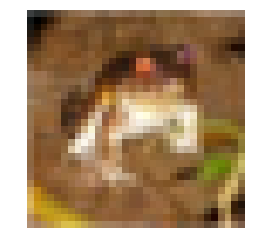


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 1:
Image - Min Value: 5 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 9 Name: truck


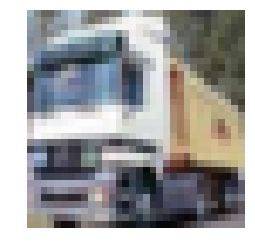


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 2:
Image - Min Value: 20 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 9 Name: truck


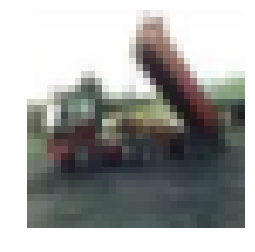


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 3:
Image - Min Value: 4 Max Value: 234
Image - Shape: (32, 32, 3)
Label - Label Id: 4 Name: deer


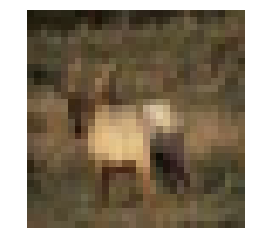


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 4:
Image - Min Value: 0 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


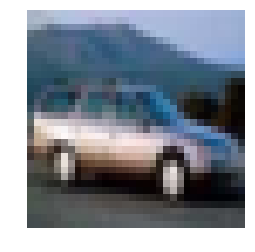

[6, 9, 4, 1, 2, 7, 8, 3, 5, 0]


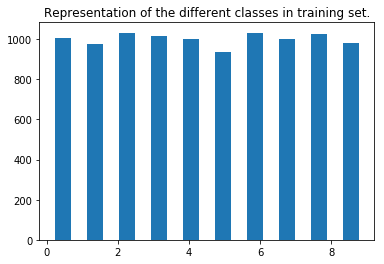

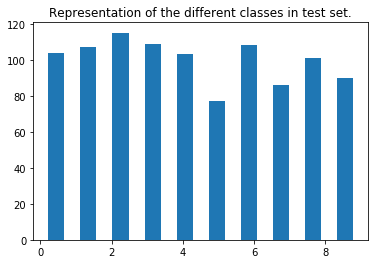

len(features2) :  5
len(labels2) :  5
After normalization: 1st batch, first five images


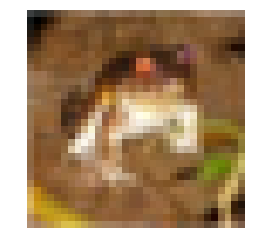

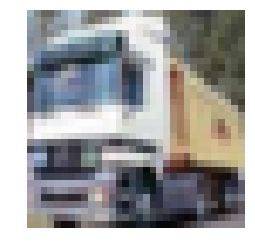

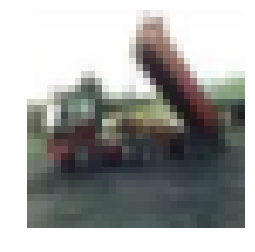

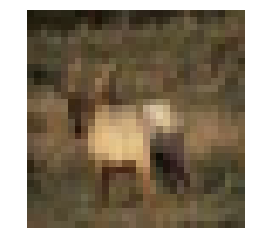

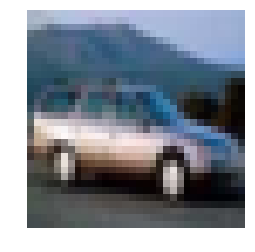

Loading and Saving Data done....Now Training


In [10]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)
print("Loading and Saving Data done....Now Training")
print('=============================================')

Run the network on pre-processed train and validation dataset.

In [11]:
train_neural_network(x, conv_network_model)
print("Training and Displaying Network done....Now Testing")
print('=============================================')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Instructions for updating:
Use `tf.global_variables_initializer` instead.
For epoch: 1, train accuracy: 0.24589999916031957, validation accuracy: 0.28900000024586914
For epoch: 2, train accuracy: 0.3239000003784895, validation accuracy: 0.31000000089406965
For epoch: 3, train accuracy: 0.3605999997071922, validation accuracy: 0.3160000011324883
For epoch: 4, train accuracy: 0.40739999959245327, validation accuracy: 0.33499999940395353
For epoch: 5, train accuracy: 0.4386999987065792, validation accuracy: 0.3449999999254942
For epoch: 6, train accuracy: 0.4674999984353781, validation accuracy: 0.36000000052154063
For epoch: 7, train accuracy: 0.5098999984934927, validation accuracy: 0.3830000013113022
For epoch: 8, train accuracy: 0.5423999997228384, validation accuracy: 0.3730000011622906
For epoch: 

Test the saved model

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './cifar_image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_testing.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model``````````````````````````````````
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
        

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        #loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('prediction:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in batch_features_labels(test_features[0:100], test_labels[0:100], batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: np.reshape(test_feature_batch, [-1, 3072]), loaded_y: test_label_batch})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))


test_model()
print("Testing Done.")
print("===============")

INFO:tensorflow:Restoring parameters from ./cifar_image_classification
Testing Accuracy: 0.4933333396911621

Testing Done.
